In [1]:
import torch
import torch.nn as nn
import zuko

from torch import Tensor
from torchvision.datasets import QMNIST
from torchvision.transforms.functional import to_tensor, to_pil_image
from typing import *

from priors.nn import *
from priors.score import *

## Data

In [2]:
dataset = QMNIST('/scratch/users/frozet/datasets/qmnist')

def measure(A, x):
    return A * x + A - 1

x = dataset.data.flatten(-2).float().cuda() / 256
x = 2 * x - 1
A = torch.rand_like(x) < 0.25
y = torch.normal(measure(A, x), 1e-2)

In [3]:
def show(x):
    x = x.repeat(1, 1, 1)
    x = x.unflatten(-1, (28, 28))

    M, N, _, _ = x.shape

    x = x.movedim(-3, -2)
    x = x.reshape(M * 28, N * 28)
    x = x.clip(-1, 1)

    return to_pil_image(x)

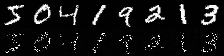

In [4]:
show(torch.stack((x[:8], y[:8])))

## Training

In [5]:
class ScoreModel(nn.Module):
    def __init__(self):
        super().__init__()

        kwargs = dict(kernel_size=3, padding=1)

        block = lambda channels: nn.Sequential(
            LayerNorm(-3),
            nn.Conv2d(channels, 2 * channels, **kwargs),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=1),
        )

        self.head = nn.Sequential(
            nn.Unflatten(-1, (1, 28, 28)),
            nn.Conv2d(1, 16, **kwargs),
        )

        self.e0 = TimeEmbedding(16)
        self.e1 = TimeEmbedding(32)
        self.e2 = TimeEmbedding(64)

        self.d1 = nn.Sequential(block(16), block(16), nn.Conv2d(16, 32, stride=2, **kwargs))
        self.d2 = nn.Sequential(block(32), block(32), nn.Conv2d(32, 64, stride=2, **kwargs))
        self.d3 = nn.Sequential(block(64), block(64), nn.Conv2d(64, 128, stride=2, **kwargs))

        self.bottleneck = nn.Sequential(
            nn.Flatten(-3),
            nn.Linear(128 * 4 * 4, 512),
            Residual(
                LayerNorm(-1),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
            ),
            nn.Linear(512, 128 * 4 * 4),
            nn.Unflatten(-1, (128, 4, 4)),
        )

        self.u3 = nn.Sequential(nn.ConvTranspose2d(128, 64, stride=2, output_padding=0, **kwargs), block(64), block(64))
        self.u2 = nn.Sequential(nn.ConvTranspose2d(64, 32, stride=2, output_padding=1, **kwargs), block(32), block(32))
        self.u1 = nn.Sequential(nn.ConvTranspose2d(32, 16, stride=2, output_padding=1, **kwargs), block(16), block(16))

        self.tail = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Flatten(-3),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        t0 = self.e0(t)[..., None, None]
        t1 = self.e1(t)[..., None, None]
        t2 = self.e2(t)[..., None, None]

        x0 = self.head(x)
        x1 = self.d1(x0 + t0)
        x2 = self.d2(x1 + t1)
        x3 = self.d3(x2 + t2)
        x3 = self.bottleneck(x3)
        x2 = self.u3(x3) + x2
        x1 = self.u2(x2) + x1
        x0 = self.u1(x1) + x0

        return self.tail(x0)

In [6]:
def sample(model, A, y):
    sde = ReverseSDE(
        PosteriorScoreModel(
            model=model,
            y=y,
            A=lambda x: measure(A, x),
            noise=1e-2,
            gamma=1e-1,  # A Gamma A^T ?
        )
    ).cuda()

    z = torch.randn_like(y)
    x_bis = sde(z, steps=256, corrections=1, tau=0.25)

    return x_bis

x_bis = sample(StandardScoreModel(), A, y)

100%|██████████| 256/256 [00:17<00:00, 14.48it/s]


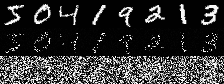

In [7]:
show(torch.stack((x[:8], y[:8], x_bis[:8])))

In [8]:
def train(x, A, y):
    sde = VPSDE()
    model = ScoreModel().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, 16384)

    for step in range(16384):
        i = torch.randint(0, len(y), (64,)).cuda()
        xi = x[i]
        Ai = A[i]

        t = torch.rand_like(xi[..., 0])
        xi, z = sde(xi, t)

        loss = (Ai * model(xi, t) - Ai * z).square().mean()
        loss.backward()

        if step % 1024 == 0:
            print(f'({step})', loss.item())

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

    return model

In [9]:
model = train(x_bis, A, y)

(0) 0.24483385682106018
(1024) 0.02187434770166874
(2048) 0.024219078943133354
(3072) 0.028432214632630348
(4096) 0.026245232671499252
(5120) 0.029767615720629692
(6144) 0.020436787977814674
(7168) 0.025888018310070038
(8192) 0.024860603734850883
(9216) 0.019755220040678978
(10240) 0.02729303389787674
(11264) 0.0317813865840435
(12288) 0.027387216687202454
(13312) 0.022233374416828156
(14336) 0.022635001689195633
(15360) 0.024161286652088165


100%|██████████| 256/256 [00:05<00:00, 44.40it/s]


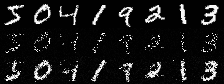

In [10]:
z = sample(model, A[:8], y[:8])
show(torch.stack((x[:8], y[:8], z)))

In [11]:
def split_sample(model, A, y, step=1024):
    return torch.cat([
        sample(model, A[i:i+step], y[i:i+step])
        for i in range(0, len(y), step)
    ])

x_bis = split_sample(model, A, y)

100%|██████████| 256/256 [00:37<00:00,  6.78it/s]


In [12]:
model = train(x_bis, A, y)

(0) 0.2619246244430542
(1024) 0.019714312627911568
(2048) 0.01662924513220787
(3072) 0.014764569699764252
(4096) 0.01686028763651848
(5120) 0.017124835401773453
(6144) 0.013394102454185486
(7168) 0.011796821840107441
(8192) 0.015985071659088135
(9216) 0.016246158629655838
(10240) 0.016666436567902565
(11264) 0.016192849725484848
(12288) 0.014284282922744751
(13312) 0.0186997689306736
(14336) 0.012663803063333035
(15360) 0.019203051924705505


100%|██████████| 256/256 [00:05<00:00, 47.15it/s]


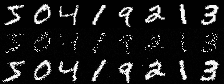

In [13]:
z = sample(model, A[:8], y[:8])
show(torch.stack((x[:8], y[:8], z)))